# Task 3: Model Explainability with SHAP

**Objective**: To interpret the predictions of the selected XGBoost fraud detection models using SHAP, identify the key drivers of fraud, understand model behavior on individual transactions, and translate insights into actionable business recommendations.

**Models Used**:
- XGBoost for Fraud_Data (AUC-PR: 0.607)
- XGBoost for CreditCard (AUC-PR: 0.813)

**Datasets**: Hold-out test sets from previous modeling (real-world imbalanced distribution).

---


## 1. Setup & Load Models/Preprocessors

In [1]:
import sys
import os
import joblib
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import xgboost as xgb

# Add project root to path
sys.path.append(os.path.abspath(".."))

from src.model_preprocessing import prepare_data_for_modeling
from src.explainability import plot_feature_importance, get_prediction_indices,get_feature_names,plot_shap_force
from sklearn.model_selection import train_test_split

# Initialize JS for SHAP plots
shap.initjs()

In [2]:
# Load saved models and preprocessors
xgb_fraud = joblib.load('../models/xgb_fraud_best.pkl')
preprocessor_fraud = joblib.load('../models/preprocessor_fraud.pkl')

xgb_cc = joblib.load('../models/xgb_creditcard_best.pkl')
preprocessor_cc = joblib.load('../models/preprocessor_creditcard.pkl')
print("Models and preprocessors loaded successfully.")

Models and preprocessors loaded successfully.


In [3]:
# Load processed data
fraud_df = pd.read_csv('../data/processed/fraud_data_engineered.csv')
cc_df = pd.read_csv('../data/processed/creditcard_processed.csv')

# Clean redundant features (same as modeling)
X_fraud_raw = fraud_df.drop(['class', 'user_total_spent', 'user_avg_purchase'], axis=1, errors='ignore')
y_fraud = fraud_df['class']

X_cc_raw = cc_df.drop('Class', axis=1)
y_cc = cc_df['Class']

In [4]:
# Re-create exact test sets (stratified split, random_state=42)
_, X_test_raw_f, _, y_test_f = train_test_split(X_fraud_raw, y_fraud, test_size=0.2, stratify=y_fraud, random_state=42)
_, X_test_raw_c, _, y_test_c = train_test_split(X_cc_raw, y_cc, test_size=0.2, stratify=y_cc, random_state=42)

# # Transform using saved fitted preprocessors
X_test_f = preprocessor_fraud.transform(X_test_raw_f)
X_test_c = preprocessor_cc.transform(X_test_raw_c)

# Get predictions for finding TP/FP/FN
y_pred_f = xgb_fraud.predict(X_test_f)
y_pred_c = xgb_cc.predict(X_test_c)

In [5]:
# Get feature names from fitted preprocessors
feature_names_f = get_feature_names(preprocessor_fraud)
feature_names_c = get_feature_names(preprocessor_cc)

print(f"Fraud_Data features after preprocessing: {len(feature_names_f)}")
print(f"CreditCard features after preprocessing: {len(feature_names_c)}")

Fraud_Data features after preprocessing: 195
CreditCard features after preprocessing: 30


## 2. Feature Importance Baseline (XGBoost Built-in)

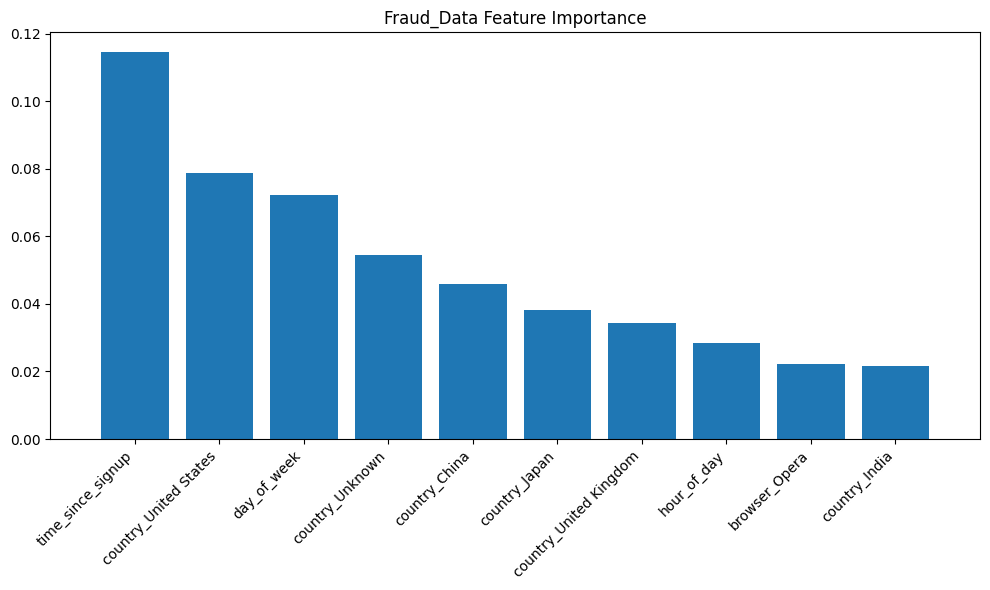

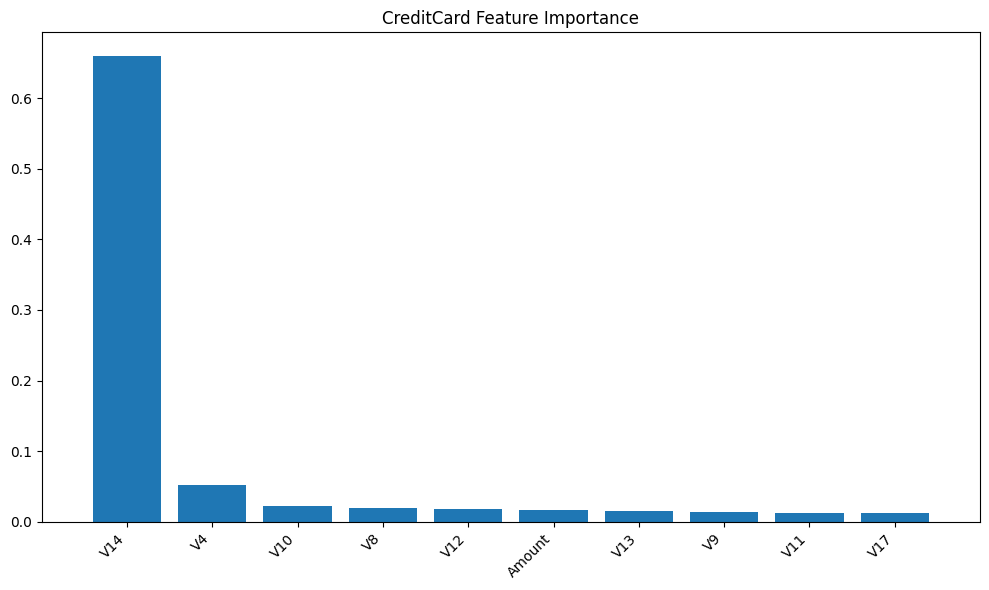

In [6]:
# Fraud_Data
plot_feature_importance(xgb_fraud, feature_names_f, title="Fraud_Data Feature Importance")

# CreditCard
plot_feature_importance(xgb_cc, feature_names_c, title="CreditCard Feature Importance")

## 3. SHAP Global Analysis 

Calculating SHAP values for Fraud_Data...
Calculating SHAP values for CreditCard...


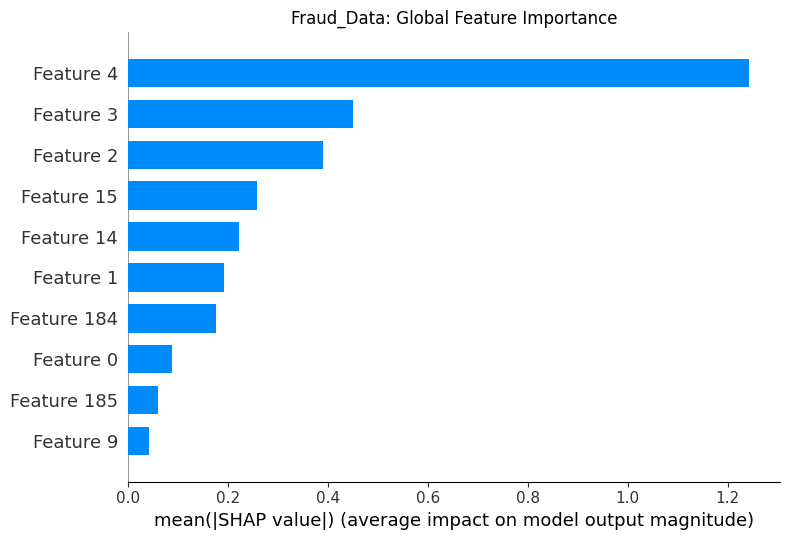

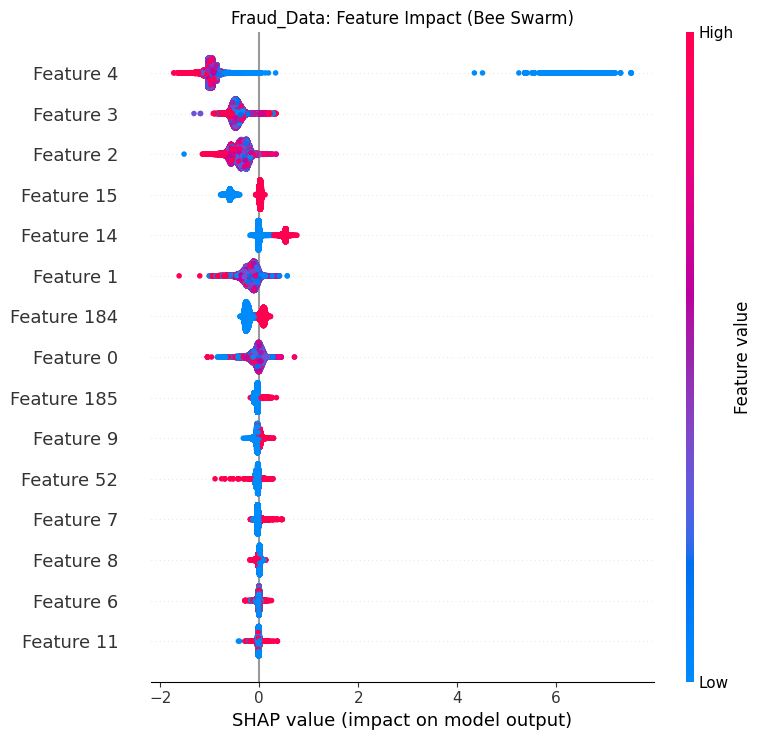

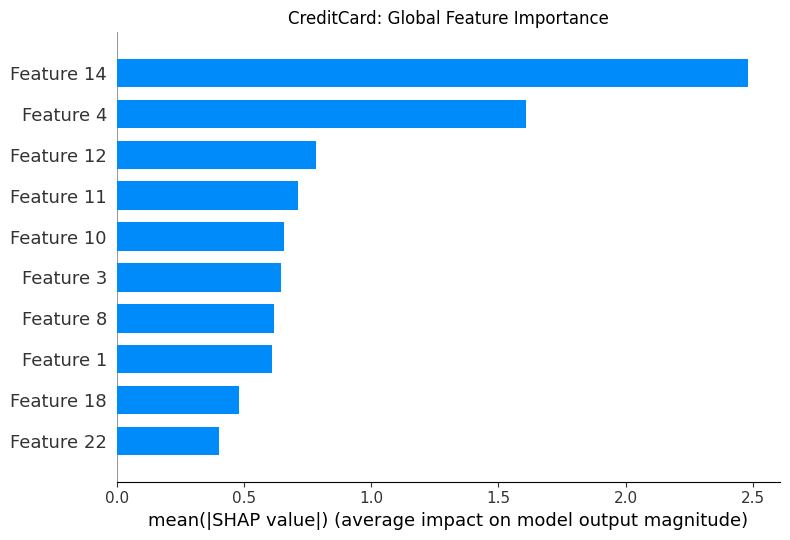

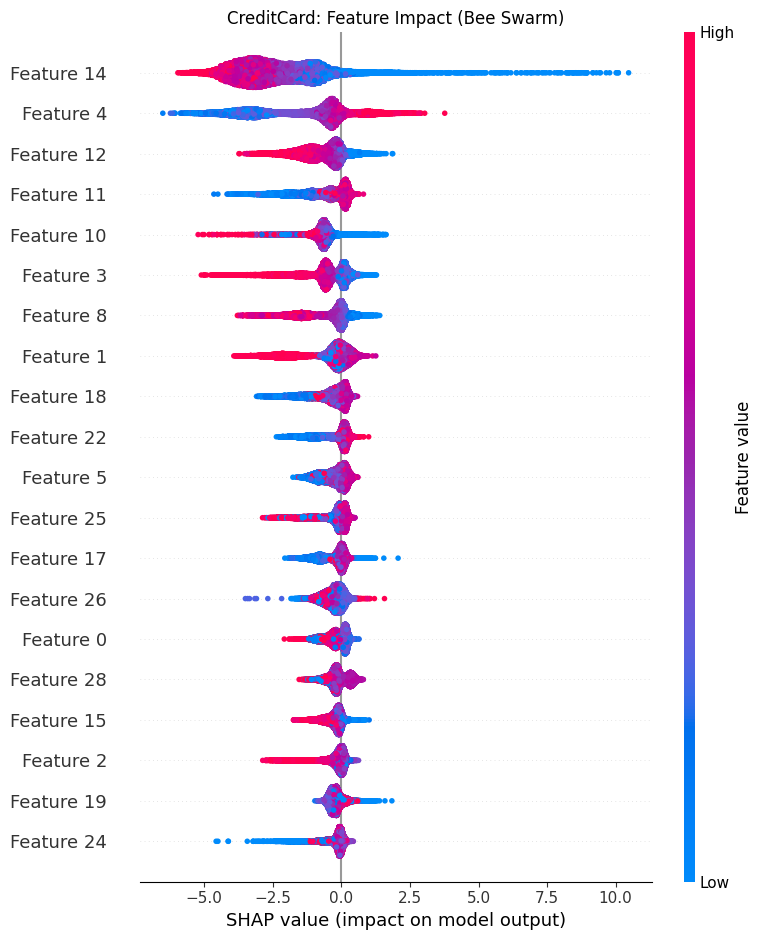

In [6]:
# 1. Create Explainers
explainer_f = shap.TreeExplainer(xgb_fraud)
explainer_c = shap.TreeExplainer(xgb_cc)

# 2. Calculate SHAP values 
print("Calculating SHAP values for Fraud_Data...")
shap_values_f = explainer_f.shap_values(X_test_f)

print("Calculating SHAP values for CreditCard...")
shap_values_c = explainer_c.shap_values(X_test_c)

# 4. Plot - Fraud_Data
plt.figure()
plt.title("Fraud_Data: Global Feature Importance")
shap.summary_plot(shap_values_f, X_test_f, plot_type="bar", show=False,max_display=10)
plt.show()

plt.figure()
plt.title("Fraud_Data: Feature Impact (Bee Swarm)")
shap.summary_plot(shap_values_f, X_test_f, show=False, max_display=15)
plt.show()

# 5. Plot - CreditCard
plt.figure()
plt.title("CreditCard: Global Feature Importance")
shap.summary_plot(shap_values_c, X_test_c, plot_type="bar", show=False,max_display=10)
plt.show()

plt.figure()
plt.title("CreditCard: Feature Impact (Bee Swarm)")
shap.summary_plot(shap_values_c, X_test_c, show=False)
plt.show()

In [6]:
explainer_f = shap.TreeExplainer(xgb_fraud)
explainer_c = shap.TreeExplainer(xgb_cc)

## 4. SHAP Local Analysis — Force Plots

In [7]:
indices_f = get_prediction_indices(y_test_f, y_pred_f)
if isinstance(X_test_f, np.ndarray):
    X_test_f = pd.DataFrame(X_test_f, columns=feature_names_f)
    print("✅ Converted X_test_f to DataFrame with feature names.")

✅ Converted X_test_f to DataFrame with feature names.


In [14]:
# Case A: True Positive (We caught a fraudster)
if len(indices_f['TP']) > 0:
    tp_idx = indices_f['TP'][0] # Take the first example
    plot_shap_force(tp_idx, explainer_f, X_test_f, "True Positive: Correctly Detected Fraud")

# Case B: False Positive (We annoyed a legitimate customer)
if len(indices_f['FP']) > 0:
    fp_idx = indices_f['FP'][0]
    plot_shap_force(fp_idx, explainer_f, X_test_f, "False Positive: Legitimate Flagged as Fraud")

# Case C: False Negative (We missed a fraudster)
if len(indices_f['FN']) > 0:
    fn_idx = indices_f['FN'][0]
    plot_shap_force(fn_idx, explainer_f, X_test_f, "False Negative: Missed Fraud")

--- True Positive: Correctly Detected Fraud (Index: 17) ---
✅ SHAP plot saved to: c:\Users\natty\Downloads\KAIM\fraud-detection\outputs\shap\true_positive_correctly_detected_fraud_17.html


--- False Positive: Legitimate Flagged as Fraud (Index: 310) ---
✅ SHAP plot saved to: c:\Users\natty\Downloads\KAIM\fraud-detection\outputs\shap\false_positive_legitimate_flagged_as_fraud_310.html


--- False Negative: Missed Fraud (Index: 2) ---
✅ SHAP plot saved to: c:\Users\natty\Downloads\KAIM\fraud-detection\outputs\shap\false_negative_missed_fraud_2.html
